# Final project. Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly 
import plotly.express as px

## Part 1. Getting to know the data, handling gaps and outliers

In [2]:
df = pd.read_csv('/Users/Anna/Study/skillfactory/practice/data_practice/bank_fin.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# check for NaN
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
# check for special attributions for NaN
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [6]:
# correction of feature 'balance'
df['balance'] = df['balance'].str.replace('$','')
df['balance'] = df['balance'].str.replace(',','.')
df['balance'] = df['balance'].str.replace(' ','')
df['balance'] = df['balance'].apply(lambda x: float(x))


In [7]:
round(df['balance'].mean(),3)

1529.129

In [8]:
df['balance']=df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(),3)


1526.936

In [9]:
# work with NaN in 'education', 'job'
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [10]:
job_replace = df['job'].mode()
edu_replace = df['education'].mode()
display(job_replace, edu_replace)

0    management
Name: job, dtype: object

0    secondary
Name: education, dtype: object

In [11]:
df['job'] = df['job'].str.replace('unknown', 'management')
df['education'] = df['education'].str.replace('unknown','secondary')

In [12]:
round(df[(df['job']=='management')&(df['education']=='secondary')]['balance'].mean(),3)

1598.883

In [13]:
# drop outliers from 'balance'
def outliers_iqr_mod(data, feature, log_scale = False, left=1.5, right=1.5):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<=lower_bound) | (x>= upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, df_clean, lower, upper = outliers_iqr_mod(df, 'balance')

In [14]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## Part 2. EDA

In [15]:
# check for balance of target feature
fig = px.histogram(
    data_frame=df_clean, 
    x = 'deposit', 
    title = 'Distribution of clients which took deposit'
)
fig.show()

In [16]:
#study of categorical and numeric data
types = df_clean.dtypes
display(types)
cat_features = list(types[(types == 'object')].index)
num_features = list(types[(types == 'int64')].index)
display(cat_features, num_features)

age            int64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day            int64
month         object
duration       int64
campaign       int64
pdays          int64
previous       int64
poutcome      object
deposit       object
dtype: object

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

['age', 'day', 'duration', 'campaign', 'pdays', 'previous']

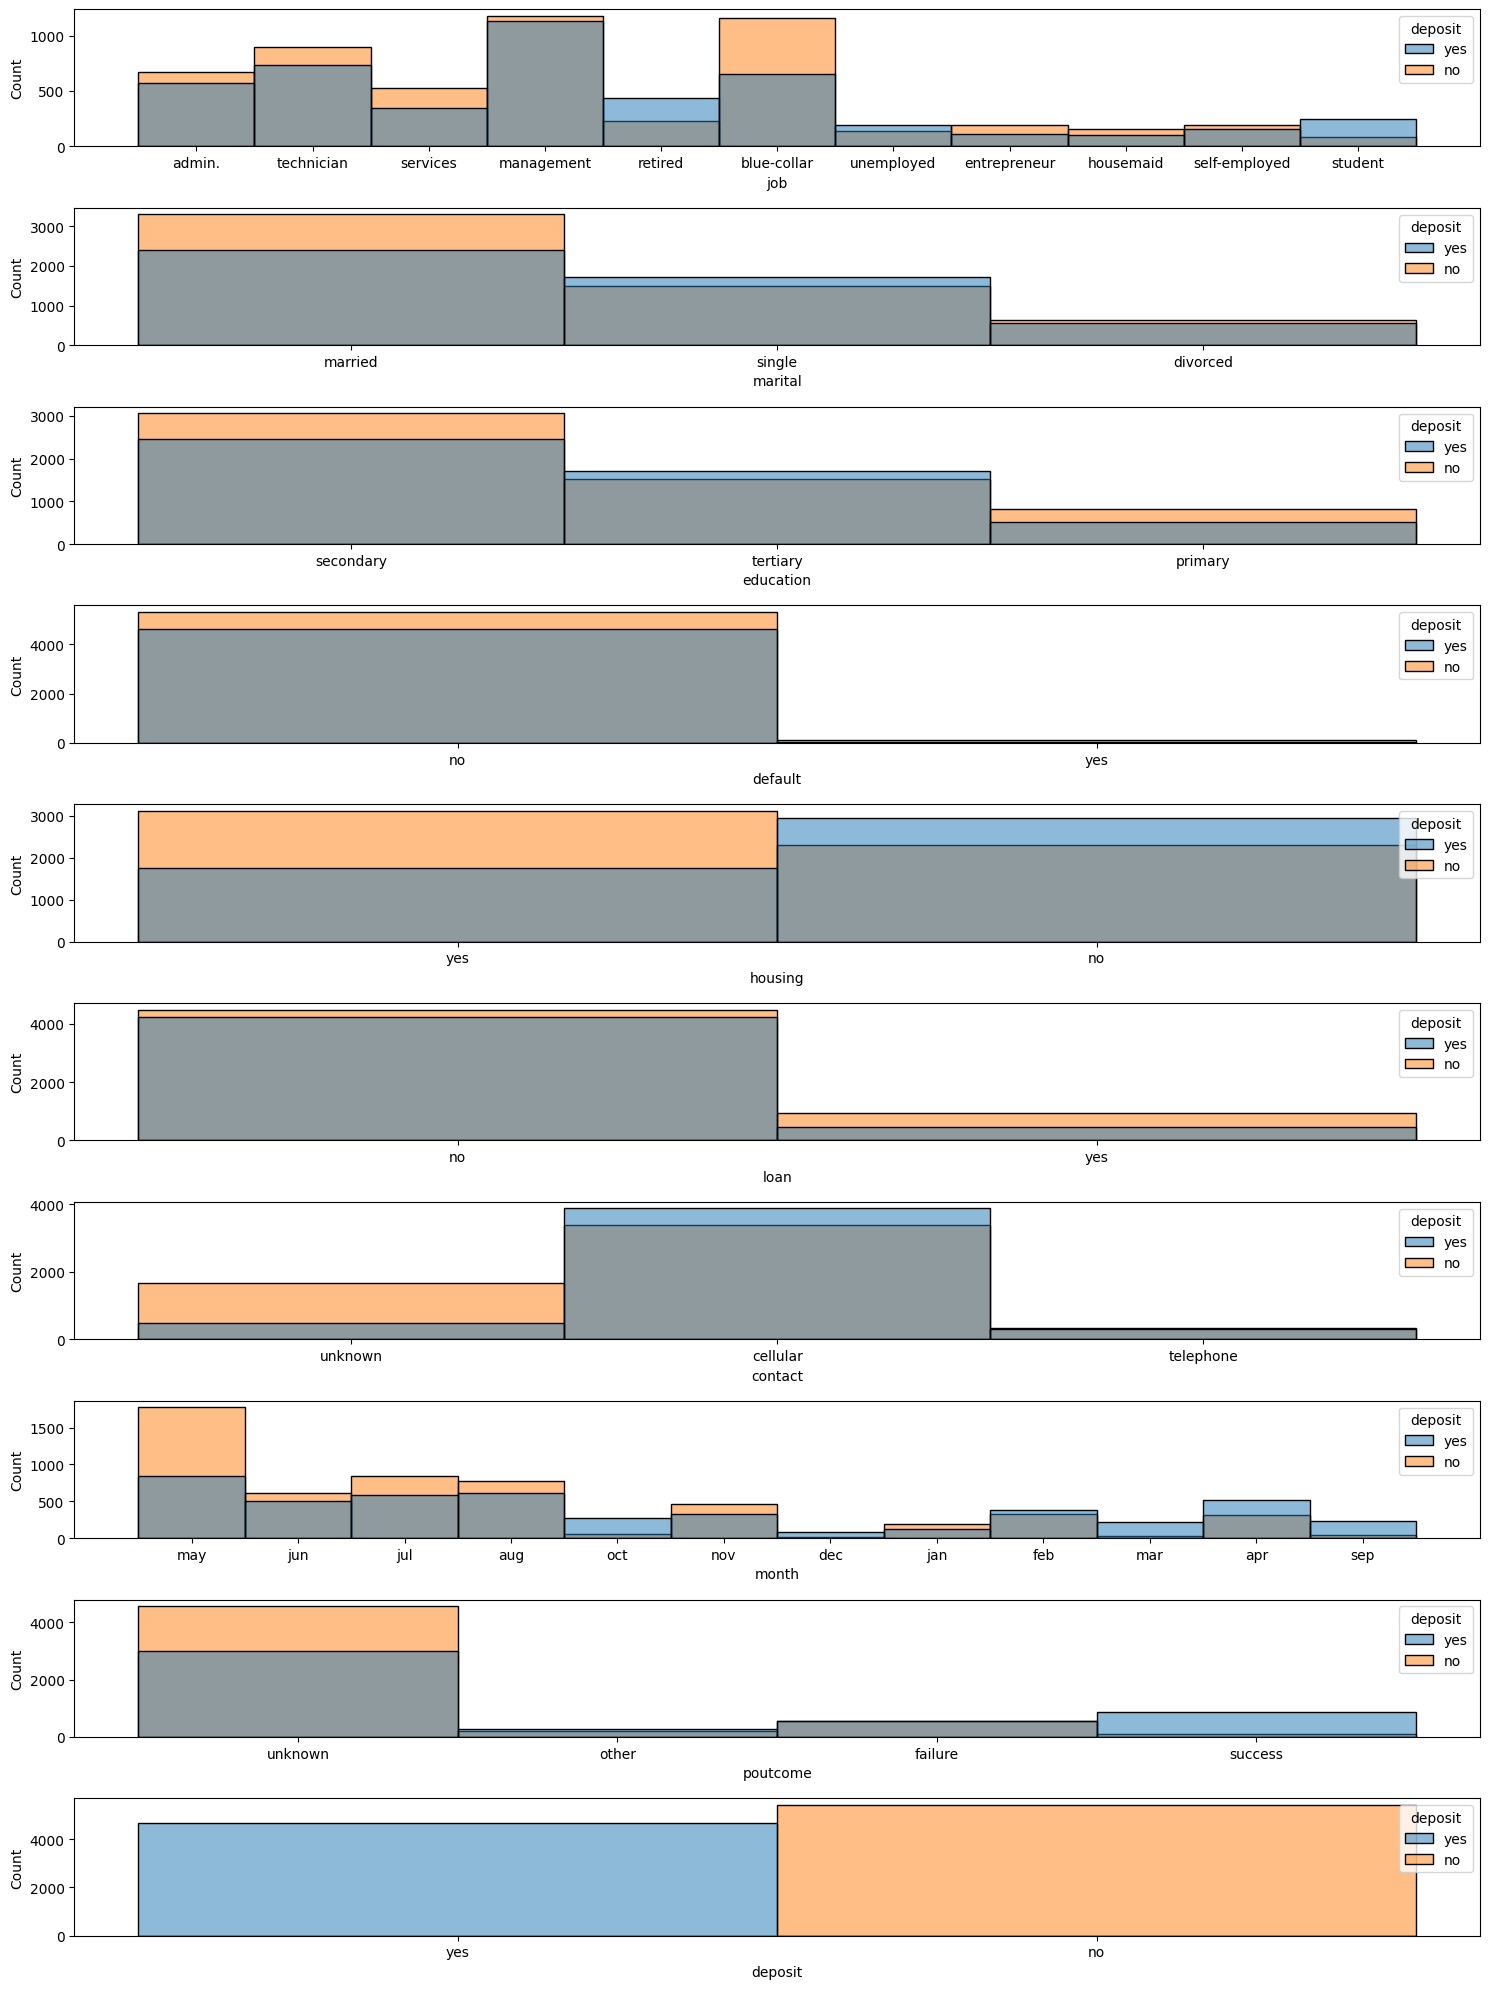

In [17]:
n = len(cat_features) 
fig, axes = plt.subplots(n, 1, figsize=(15, 20))
for i, feature in enumerate(cat_features):
    fig = sns.histplot(data=df_clean, hue='deposit', x= feature, ax = axes[i])
plt.tight_layout()

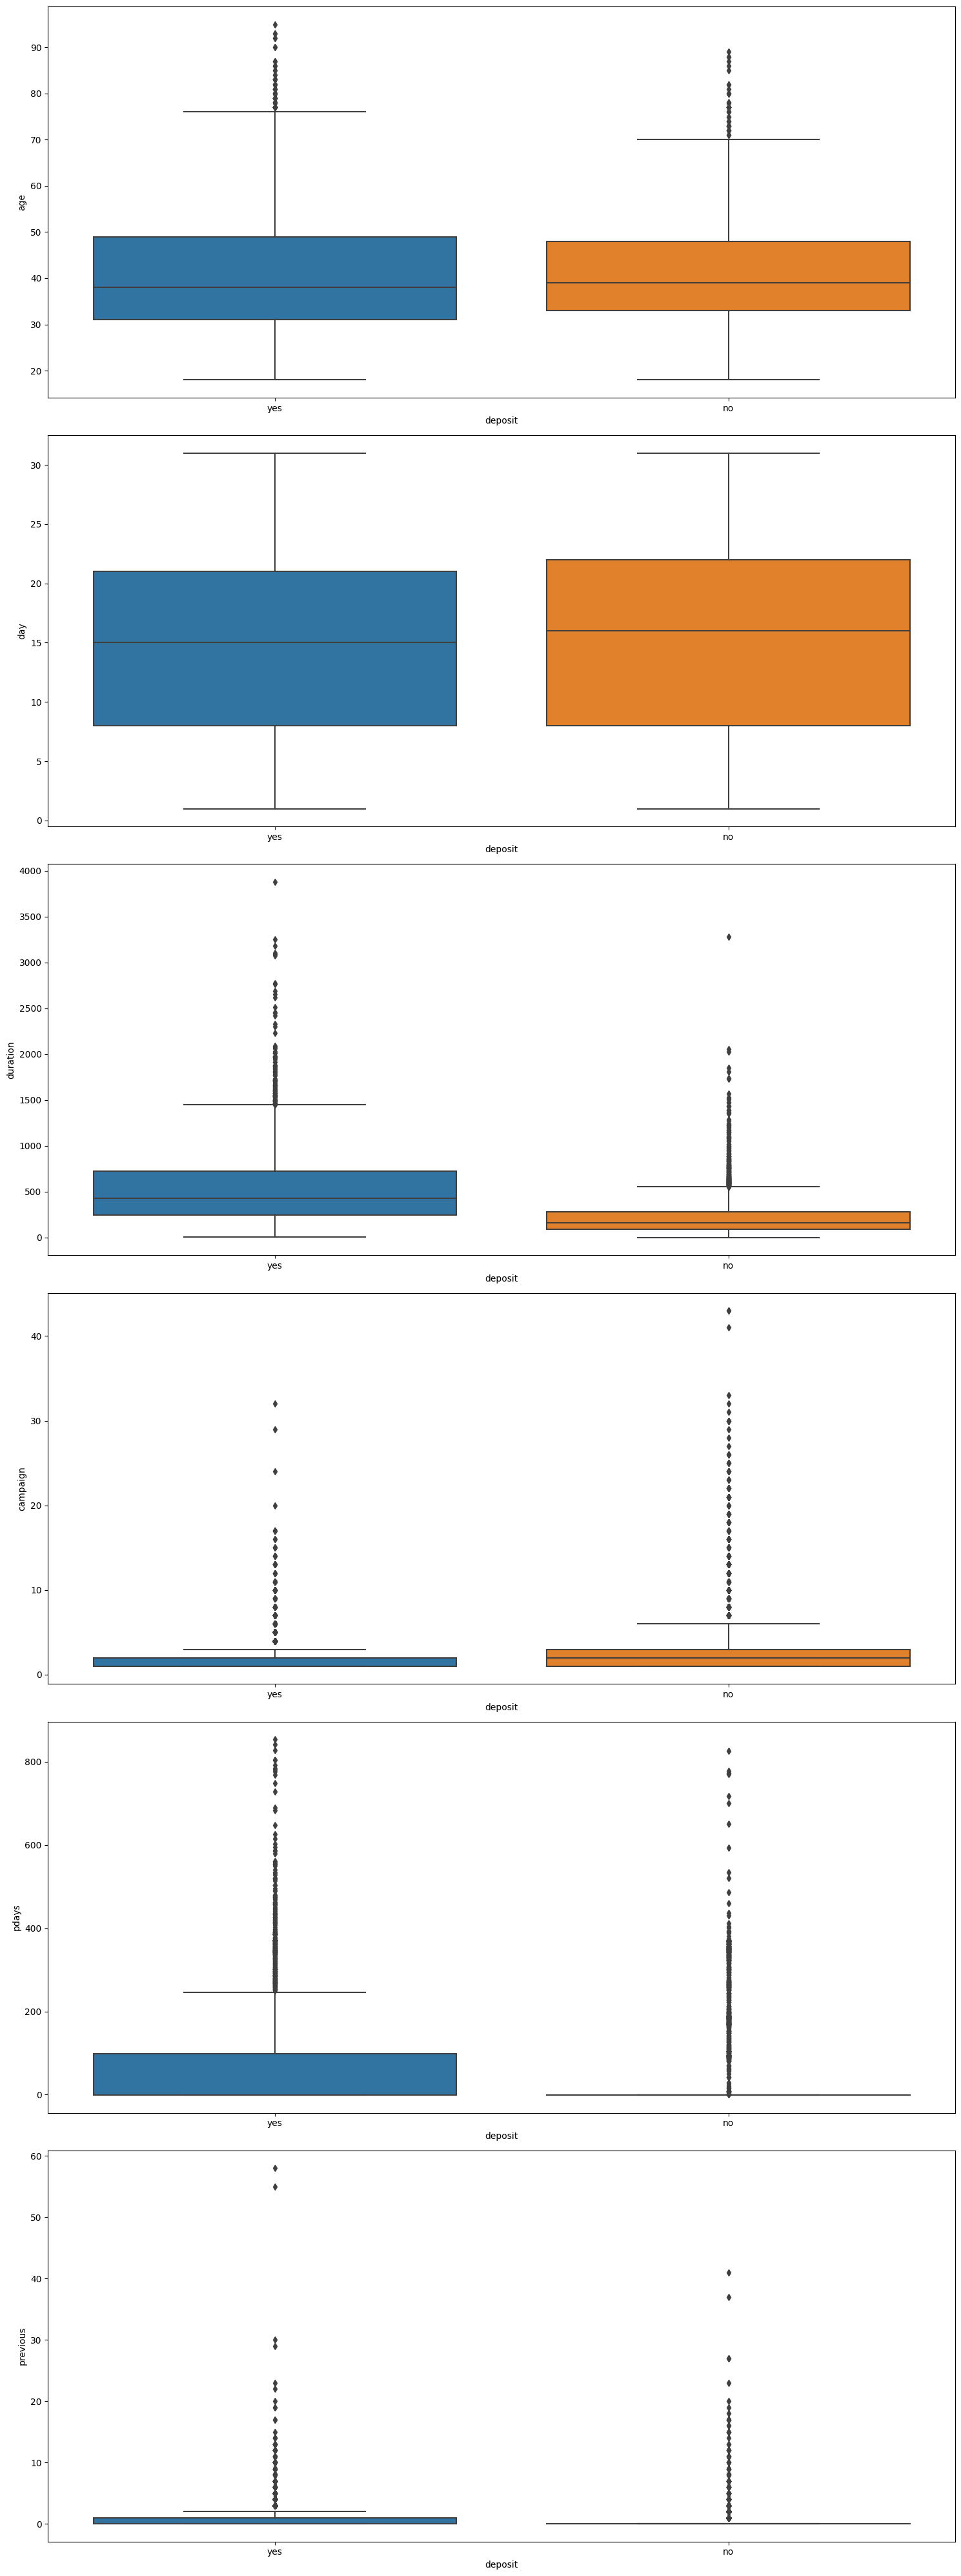

In [18]:
n = len(num_features) 
fig, axes = plt.subplots(n, 1, figsize=(15, 40))
for i, feature in enumerate(num_features):
    fig = sns.boxplot(data=df_clean, x='deposit', y= feature, ax = axes[i])
plt.tight_layout()

In [19]:
df_clean.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [20]:
# transformation of 'age'
def age_gr(el):
    if el<30:
       return 2
    elif 30<el<40:
        return 3
    elif 40<el<50:
        return 4
    elif 50<el<60:
        return 5
    else:
        return 6
df_clean['age_group'] = df_clean['age'].apply(age_gr)
df_clean['age_group'].value_counts()

3    3546
4    2086
6    1533
5    1485
2    1455
Name: age_group, dtype: int64

In [21]:
fig_data = df_clean.groupby(['age_group'], as_index=False)['deposit'].value_counts(normalize = True)
display(fig_data)
fig = px.bar(
    data_frame=fig_data, 
    x = 'age_group', 
    y='proportion',
    color = 'deposit',
    title = 'Distribution of clients which took deposit'
)
fig.show()

,age_group,deposit,proportion
0,2,yes,0.591753
1,2,no,0.408247
2,3,no,0.569656
3,3,yes,0.430344
4,4,no,0.598754
5,4,yes,0.401246
6,5,no,0.587879
7,5,yes,0.412121
8,6,yes,0.551207
9,6,no,0.448793


In [22]:
# visualizations for those who have opened and not opened a deposit depending on marital status
fig_data = df_clean.groupby(['marital'], as_index=False)['deposit'].value_counts(normalize = True)
display(fig_data)
fig = px.bar(
    data_frame=fig_data, 
    x = 'marital', 
    y='proportion',
    color = 'deposit',
    title = 'Distribution of clients which took deposit'
)
fig.show()

,marital,deposit,proportion
0,divorced,no,0.530161
1,divorced,yes,0.469839
2,married,no,0.577953
3,married,yes,0.422047
4,single,yes,0.534080
5,single,no,0.465920


<AxesSubplot: xlabel='count', ylabel='marital'>

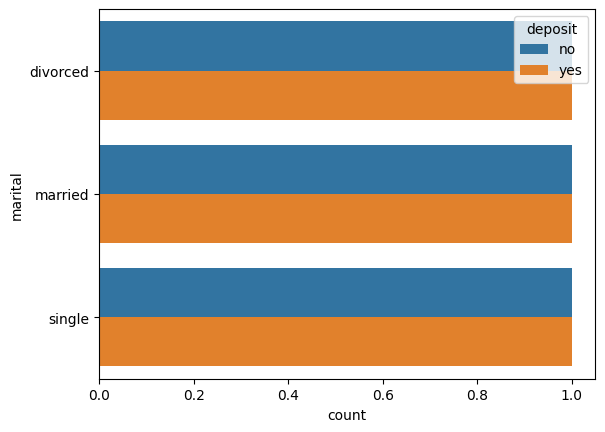

In [23]:
sns.countplot(y='marital', hue = 'deposit', data = fig_data)

In [24]:
# visualizations for those who have opened and not opened a deposit, depending on the education
fig_data = df_clean.groupby(['education'], as_index=False)['deposit'].value_counts(normalize = True)
display(fig_data)
fig = px.bar(
    data_frame=fig_data, 
    x = 'education', 
    y='proportion',
    color = 'deposit',
    title = 'Distribution of clients which took deposit'
)
fig.show()

,education,deposit,proportion
0,primary,no,0.616753
1,primary,yes,0.383247
2,secondary,no,0.555737
3,secondary,yes,0.444263
4,tertiary,yes,0.528867
5,tertiary,no,0.471133


In [25]:
# visualizations for those who have opened and not opened a deposit, depending on the type of professional employment
fig_data = df_clean.groupby(['job'], as_index=False)['deposit'].value_counts(normalize = True)
display(fig_data)
fig = px.bar(
    data_frame=fig_data, 
    x = 'job', 
    y='proportion',
    color = 'deposit',
    title = 'Distribution of clients which took deposit'
)
fig.show()

,job,deposit,proportion
0,admin.,no,0.539326
1,admin.,yes,0.460674
2,blue-collar,no,0.639181
3,blue-collar,yes,0.360819
4,entrepreneur,no,0.630000
5,entrepreneur,yes,0.370000
6,housemaid,no,0.607143
7,housemaid,yes,0.392857
8,management,no,0.509719
9,management,yes,0.490281


Divide the table into two parts: for those who opened a deposit, and for those who did not. For each part, build a summary chart by educational level and marital status. Present the results as heat maps. 

In [26]:
df_yes = df_clean[df_clean['deposit']=='yes'].groupby(['marital', 'education'], as_index=False)['deposit'].value_counts()
df_no = df_clean[df_clean['deposit']=='no'].groupby(['marital', 'education'], as_index=False)['deposit'].value_counts()

pivot = df_yes.pivot_table(
    index = 'marital', 
    columns = 'education', 
    values = 'count'
)
display(pivot)
fig = px.imshow(
    pivot,
    title ='Relationship between customer loyalty and credit rating and the number of years of using bank services'
)
fig.show()

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


In [27]:
pivot = df_no.pivot_table(
    index = 'marital', 
    columns = 'education', 
    values = 'count'
)
display(pivot)
fig = px.imshow(
    pivot,
    title ='Relationship between customer loyalty and credit rating and the number of years of using bank services'
)
fig.show()

education,primary,secondary,tertiary
marital,,,
divorced,91,370,163
married,641,1830,832
single,100,866,531


## Part 3: Data transformation

In [28]:
le = preprocessing.LabelEncoder()
df_clean['education'] = le.fit_transform(df_clean.education)
df_clean['education'].sum()


11995

In [29]:
from sklearn.preprocessing import LabelBinarizer
transformer = preprocessing.LabelBinarizer()
df_clean['deposit'] = transformer.fit_transform(df_clean.deposit)
round(df_clean['deposit'].std(),3)

0.499

In [30]:
df_clean['default'] = transformer.fit_transform(df_clean.default)
df_clean['housing'] = transformer.fit_transform(df_clean.housing)
df_clean['loan'] = transformer.fit_transform(df_clean.loan)
round((df_clean['default'].mean()+df_clean['housing'].mean()+df_clean['loan'].mean()),3)

0.635

In [31]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  int64  
 4   default    10105 non-null  int64  
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  int64  
 7   loan       10105 non-null  int64  
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  int64  
 17  age_group  10105 non-null  int64  
dtypes: float64(1), int64(12), object(5)
memory usage: 1.5+ MB


In [32]:
cols = ['job','marital','contact','month','poutcome']
dummie = pd.get_dummies(df_clean[cols], drop_first=True)
df_clean = pd.concat([df_clean, dummie], axis=1)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   job                10105 non-null  object 
 2   marital            10105 non-null  object 
 3   education          10105 non-null  int64  
 4   default            10105 non-null  int64  
 5   balance            10105 non-null  float64
 6   housing            10105 non-null  int64  
 7   loan               10105 non-null  int64  
 8   contact            10105 non-null  object 
 9   day                10105 non-null  int64  
 10  month              10105 non-null  object 
 11  duration           10105 non-null  int64  
 12  campaign           10105 non-null  int64  
 13  pdays              10105 non-null  int64  
 14  previous           10105 non-null  int64  
 15  poutcome           10105 non-null  object 
 16  deposit            101

In [33]:
df_clean.drop(cols, axis = 1, inplace=True)

In [34]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int64  
 13  job_blue-collar    10105 non-null  uint8  
 14  job_entrepreneur   10105 non-null  uint8  
 15  job_housemaid      10105 non-null  uint8  
 16  job_management     101

<function matplotlib.pyplot.show(close=None, block=None)>

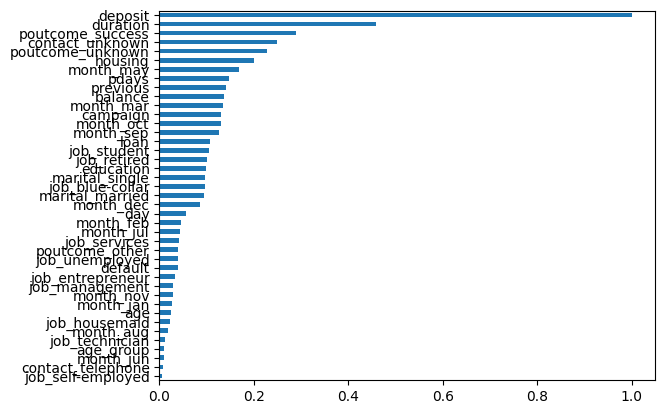

In [35]:
df_clean.corr()['deposit'].apply(lambda x: abs(x)).sort_values().plot.barh()
plt.show

<AxesSubplot: >

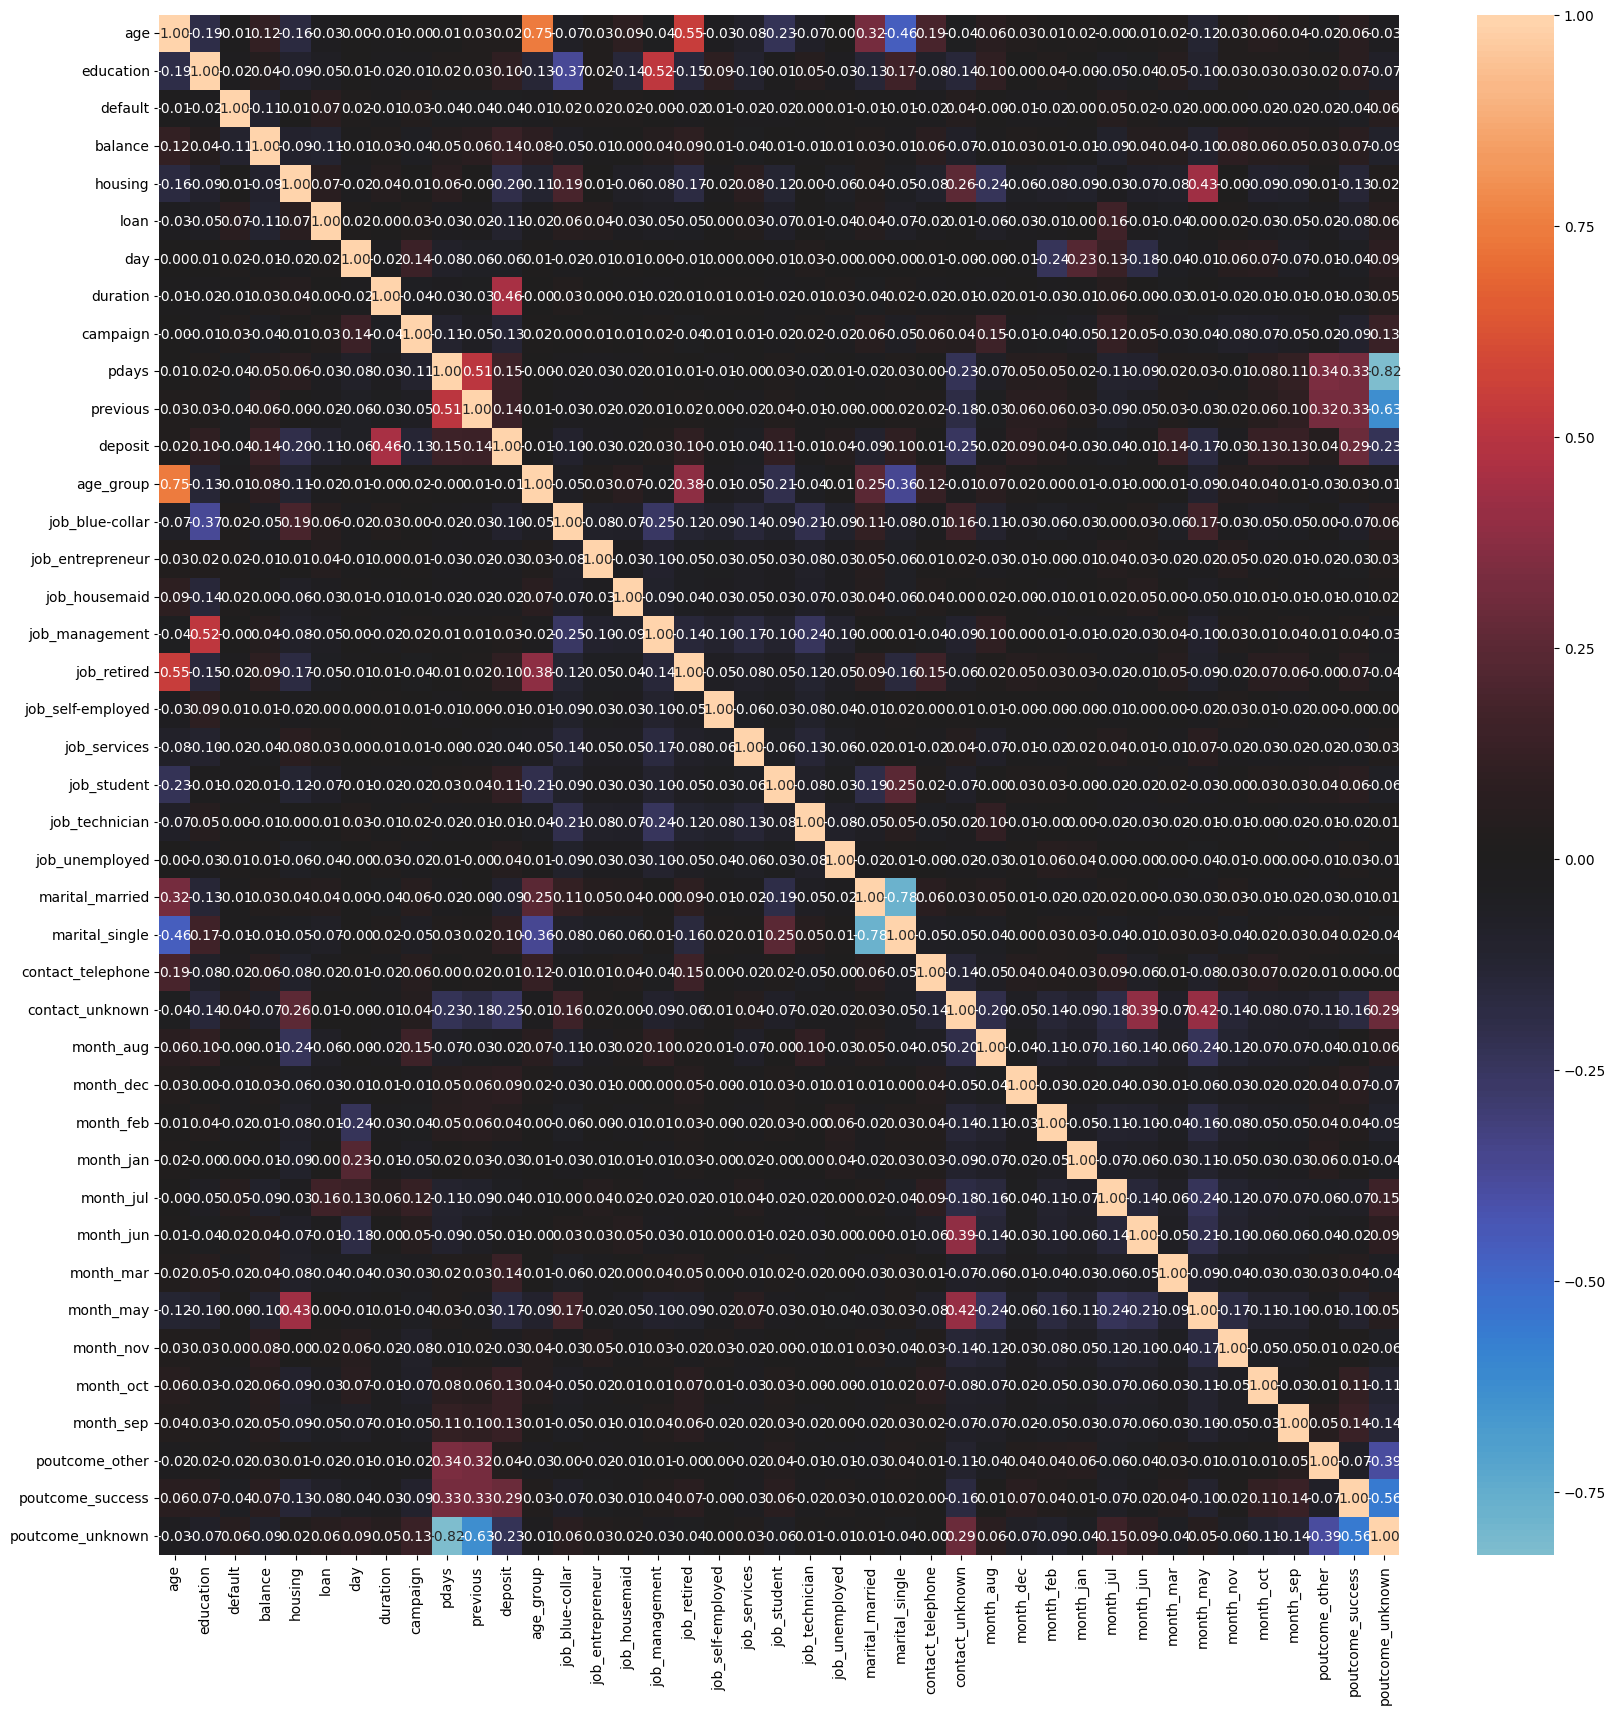

In [36]:
plt.figure(figsize=(20,20))  
sns.heatmap(df_clean.corr(),fmt='.2f',annot=True, center=0)

In [37]:
X = df_clean.drop(['deposit'], axis=1)
y = df_clean['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
X_test.shape

(3335, 40)

In [38]:
#Selection of 15 features
from sklearn.feature_selection import f_classif, SelectKBest # anova
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()


array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'job_student', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [39]:
cols = ['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'job_student', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown']
X_train, X_test = X_train[cols], X_test[cols]
X_test

,balance,housing,loan,duration,campaign,pdays,previous,job_student,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
3333,155.0,0,0,290,1,93,2,0,0,1,0,0,0,1,0
6048,512.0,0,0,70,1,-1,0,0,0,0,0,0,0,0,1
5675,1403.0,0,0,214,8,326,2,0,0,0,1,0,0,0,0
2564,1270.0,0,0,232,3,-1,0,0,0,0,0,0,0,0,1
8983,1074.0,1,0,523,2,-1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,507.0,0,0,380,1,-1,0,0,0,0,0,0,0,0,1
9672,443.0,0,0,10,1,2,1,0,0,0,0,0,0,0,0
8584,-311.0,1,0,55,2,345,2,0,0,0,1,0,0,0,0
10972,250.0,0,1,133,1,-1,0,0,0,0,0,0,0,0,1


In [41]:
#normalization
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns= X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [42]:
X_test_scaled

,balance,housing,loan,duration,campaign,pdays,previous,job_student,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
0,0.360602,0.0,0.0,0.074246,0.000000,0.109942,0.034483,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.419012,0.0,0.0,0.017530,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.564791,0.0,0.0,0.054653,0.166667,0.382456,0.034483,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.543030,0.0,0.0,0.059294,0.047619,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.510962,1.0,0.0,0.134313,0.023810,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3330,0.418194,0.0,0.0,0.097448,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3331,0.407723,0.0,0.0,0.002062,0.000000,0.003509,0.017241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3332,0.284359,1.0,0.0,0.013663,0.023810,0.404678,0.034483,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3333,0.376145,0.0,1.0,0.033772,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
X_test_scaled['balance'].mean()

0.46823674223097655

# Part 4: Solving the Classification Problem: Logistic Regression and Decision Trees

In [44]:
# Logistic regression
log_reg = linear_model.LogisticRegression(random_state=42, solver = 'sag', max_iter=1000)

log_reg.fit(X_train_scaled, y_train)

y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred_test)))


Accuracy: 0.82
Accuracy: 0.81


In [46]:
# Decision Tree
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42,
    max_depth=11
)

dt_clf.fit(X_train_scaled, y_train)
y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_train, y_pred_train))
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.86      0.83      1790
           1       0.82      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.80      3335



In [47]:
# Search for optimal parameters
from sklearn.model_selection import GridSearchCV
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'saga'], 
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, 
        max_iter=1000 
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy for test sample: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score for test sample: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("The best hyperparameters: {}".format(grid_search.best_params_))

CPU times: user 255 ms, sys: 202 ms, total: 457 ms
Wall time: 2.56 s
accuracy for test sample: 0.80
f1_score for test sample: 0.78
The best hyperparameters: {'penalty': 'none', 'solver': 'lbfgs'}


In [48]:
param_grid = {'min_samples_leaf': [2, 5, 7, 10],
              'max_depth': [3,5,7],
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid = param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy for test sample: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score for test sample: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("The best hyperparameters: {}".format(grid_search_tree.best_params_))

CPU times: user 174 ms, sys: 33.2 ms, total: 207 ms
Wall time: 314 ms
accuracy for test sample: 0.79
f1_score for test sample: 0.79
The best hyperparameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10}


# Part 5: Solving the classification problem: ensembles of models and building a forecast

In [49]:
# Random forest
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=100, 
    criterion='gini',
    max_depth=10, 
    max_features='sqrt', 
    random_state=42, 
    min_samples_leaf = 5
)

rf_clf_full.fit(X_train_scaled, y_train)


y_pred_test = rf_clf_full.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1790
           1       0.81      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [50]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

gb = GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300, 
    max_depth=5, 
    random_state=42, 
    min_samples_leaf = 5
)

gb.fit(X_train_scaled, y_train)

y_pred_test = gb.predict(X_test_scaled)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [51]:
# Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('dt',  DecisionTreeClassifier(
        criterion='entropy', 
        random_state=42,
        max_depth=10)),
    ('gb', GradientBoostingClassifier(
        learning_rate=0.05, 
        n_estimators=300, 
        max_depth=5, 
        random_state=42, 
        min_samples_leaf = 5)),
    ('log', LogisticRegression(
        random_state=42,
        solver = 'sag', 
        max_iter=1000
    ))
]


reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
                                          random_state=42)
)

reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42)),
                               ('log',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag'))],
                   final_estimator=LogisticRegression(random_state=42))

In [52]:
y_pred_stack = reg.predict(X_test_scaled)

print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



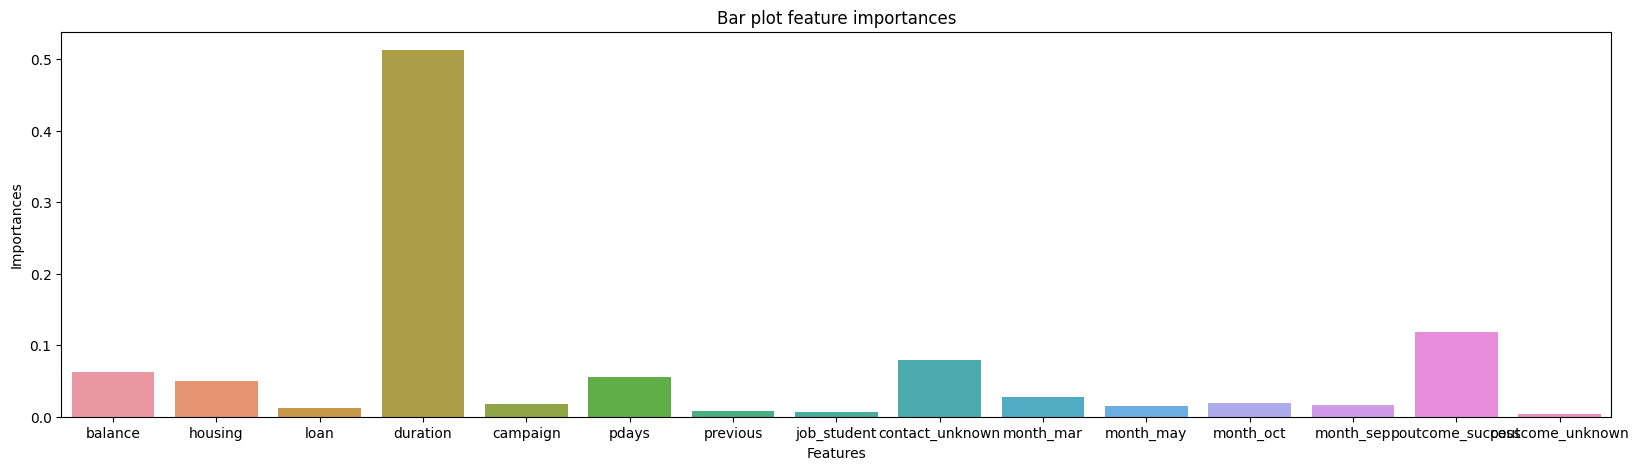

In [53]:
# evaluate which features show the greatest importance in the gradient boosting model
fig, ax = plt.subplots(figsize=(20, 5)) 
feature = X_train_scaled.columns 
feature_importances = gb.feature_importances_ 

sns.barplot(x=feature, y=feature_importances, ax=ax);

ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

In [54]:
# Optuna optimization
import optuna
random_state = 42
def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

print("The best hyperparameters {}".format(study.best_params))
print("f1_score for train sample: {:.2f}".format(study.best_value))

[I 2023-05-09 18:16:18,503] A new study created in memory with name: RandomForestClassifier
[I 2023-05-09 18:16:18,917] Trial 0 finished with value: 0.8440050219711238 and parameters: {'n_estimators': 118, 'max_depth': 20, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8440050219711238.
[I 2023-05-09 18:16:19,603] Trial 1 finished with value: 0.8608586649952993 and parameters: {'n_estimators': 176, 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8608586649952993.
[I 2023-05-09 18:16:20,116] Trial 2 finished with value: 0.8425838820947005 and parameters: {'n_estimators': 145, 'max_depth': 28, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8608586649952993.
[I 2023-05-09 18:16:20,521] Trial 3 finished with value: 0.8604978863316111 and parameters: {'n_estimators': 102, 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8608586649952993.
[I 2023-05-09 18:16:21,183] Trial 4 finished with value: 0.8659890539483972 and parameters: {'n

The best hyperparameters {'n_estimators': 199, 'max_depth': 24, 'min_samples_leaf': 2}
f1_score for train sample: 0.92


In [55]:
# metrics for test sample
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy for test samples: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score for test samples: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy for test samples: 0.83
f1_score for test samples: 0.82
